In [2]:
import random
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
from scipy.integrate import odeint

from numpy import linalg as la

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from gMLV import *

In [3]:
def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)

In [6]:
# some plotting functions

cols = ["red", "green", "blue", "royalblue","orange", "black"]

def plot_gMLV(yobs, sobs, timepoints):
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    fig, axs = plt.subplots(1, 2)
    for species_idx in range(yobs.shape[1]):
        axs[0].plot(timepoints, yobs[:, species_idx], color=cols[species_idx])
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]')
    if sobs.shape[1] > 0:
        for metabolite_idx in range(sobs.shape[1]):
            axs[1].plot(timepoints, sobs[:, metabolite_idx], color=cols[metabolite_idx])
        axs[1].set_xlabel('time')
        axs[1].set_ylabel('[metabolite]');

def plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, timepoints):
    # plot the fit
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    fig, axs = plt.subplots(1, 2)
    
    for species_idx in range(yobs.shape[1]):
        axs[0].plot(timepoints, yobs[:, species_idx], color=cols[species_idx])
        axs[0].plot(timepoints, yobs_h[:, species_idx], '--', color=cols[species_idx])
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]');

    for metabolite_idx in range(sobs.shape[1]):
        axs[1].plot(timepoints, sobs[:, metabolite_idx], color=cols[metabolite_idx])
        axs[1].plot(timepoints, sobs_h[:, metabolite_idx], '--', color=cols[metabolite_idx])
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('[metabolite]');

def compare_params(mu=None, M=None, alpha=None, e=None):
    # each argument is a tuple of true and predicted values
    if mu is not None:
        print("mu_hat/mu:")
        print(np.array(mu[1]))
        print(np.array(mu[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0,len(mu[0]), dtype="int32"), np.array(mu[1]), markerfmt="D")
        ax.stem(np.arange(0,len(mu[0]), dtype="int32"), np.array(mu[0]), markerfmt="X")
        ax.set_xlabel('i')
        ax.set_ylabel('mu[i]');

    if M is not None:
        print("\nM_hat/M:")
        print(np.round(np.array(M[1]), decimals=2))
        print("\n",np.array(M[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, M[0].shape[0] ** 2), np.array(M[1]).flatten(), markerfmt="D")
        ax.stem(np.arange(0, M[0].shape[0] ** 2), np.array(M[0]).flatten(), markerfmt="X")
        ax.set_ylabel('M[i,j]');

    if alpha is not None:
        print("\na_hat/a:")
        print(np.round(np.array(alpha[1]), decimals=2))
        print("\n",np.array(alpha[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, alpha[0].shape[0] * alpha[0].shape[1]), np.array(alpha[1]).flatten(), markerfmt="D")
        ax.stem(np.arange(0, alpha[0].shape[0] * alpha[0].shape[1]), np.array(alpha[0]).flatten(), markerfmt="X")
        ax.set_ylabel('a[i,j]');

    if e is not None:
        print("\ne_hat/e:")
        print(np.round(np.array(e[1]), decimals=2))
        print("\n",np.array(e[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, e[0].shape[0]), np.array(e[1]).flatten(), markerfmt="D")
        ax.stem(np.arange(0, e[0].shape[0]), np.array(e[0]).flatten(), markerfmt="X")
        ax.set_ylabel('e[i]');


## Simulate some time course data and perform ridge regression as in Stein et al. 2013
I have coded up the Stein model and ridge regression without the perturbation term (Ridge1) and with a single perturbation (Ridge 2). <br>
Ridge regression is designed to cause shrinkage to prevent overfitting. It isn't supposed to be used for variable
selection. We should use Lasso for this, however I think we need to constrain parameters.

# Five species, single time course

number of species: 5
specific growth rates: [1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]
interaction matrix: 
[[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
metabolite production: 
None
perturbation matrix: 
[]
minimum found: a0/a1/error: 0.06951927961775606 0.0003359818286283781 0.10405332708609238
unconstrained error        : 0.10508759597521786
mu_hat/mu:
[ 3.49527384  1.37524268  3.77460614  0.2759617  12.15587567]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.29 -0.12  0.07  0.08 -0.05]
 [-0.15 -0.18  0.09  0.1   0.01]
 [ 0.24  0.11 -0.47 -0.07 -0.13]
 [ 0.09  0.06 -0.04 -0.05 -0.01]
 [-0.12 -0.08 -0.5   0.05 -0.68]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2

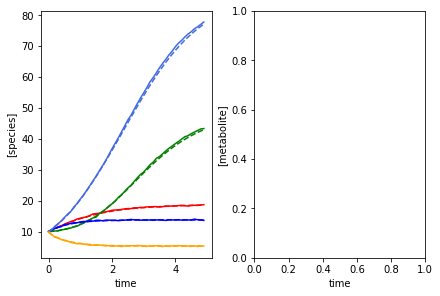

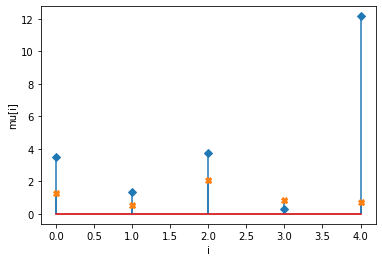

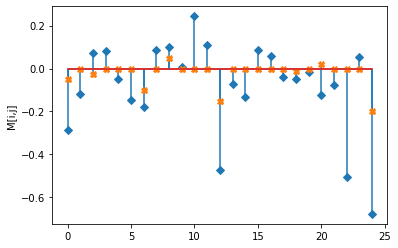

In [5]:
# In this example n >> p and it it is basically same as standard regression
# We have to be careful as most of these gLV models are very weakly identifiable

set_all_seeds(1234)

## SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
#TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu)
simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
# plot_gMLV(yobs, sobs, times)

## PERFORM REGRESSION
# linearise
X, F = linearize_time_course_16S(yobs, times)
# print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

# get the best lambda/alpha values on a grid via cross validation
a0, a1 = fit_alpha_Ridge1(X, F, num_species=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0, a1)
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu,mu_h), M=(M, M_h))


# Five species, lower number of time points, multiple time course

number of species: 5
specific growth rates: [1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]
interaction matrix: 
[[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
metabolite production: 
None
perturbation matrix: 
[]
X: (12, 6)
F: (12, 5)
n: 60, p: 30
minimum found: a0/a1/error: 1.2742749857031335 3.792690190732254e-05 0.040851666358237754
unconstrained error        : 0.07450427435040181
mu_hat/mu:
[0.41552428 0.88691095 0.40526676 0.6406298  0.15583877]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.02 -0.    0.    0.   -0.01]
 [-0.02 -0.03  0.    0.01  0.  ]
 [-0.   -0.01 -0.03  0.   -0.  ]
 [ 0.    0.   -0.01 -0.01  0.01]
 [ 0.   -0.   -0.01  0.   -0.04]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0

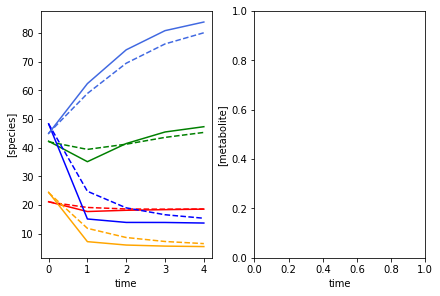

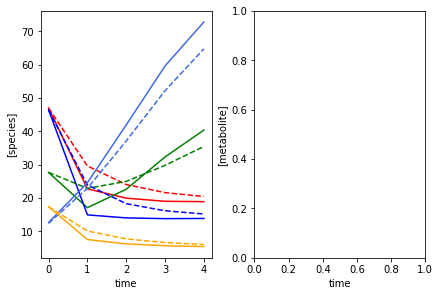

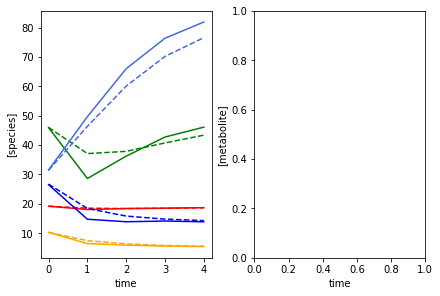

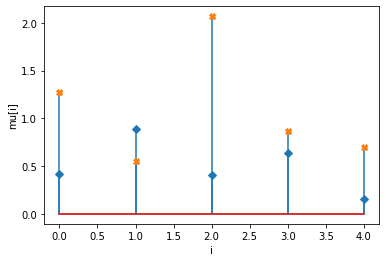

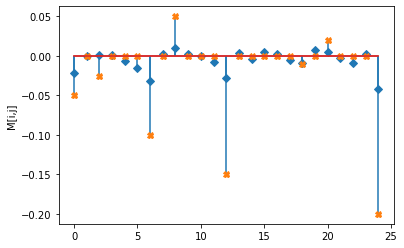

In [7]:
set_all_seeds(1234)

## SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
#TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu)
simulator.print()

## PRODUCE SIMULATED RESULTS
# data structures for results
ryobs = []
rsobs = []
ry0 = []
rs0 = []
X = np.array([], dtype=np.double).reshape(0, num_species+1)
F = np.array([], dtype=np.double).reshape(0, num_species)

num_timecourses = 3
times = np.arange(0,5,1)
for timecourse_idx in range(num_timecourses):
    # initial conditions
    init_species = np.random.uniform(low=10, high=50, size=num_species)
    init_metabolites = np.random.uniform(low=10, high=50, size=num_metabolites)

    yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

    # add some gaussian noise
    yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
    sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

    # append results
    ryobs.append(yobs)
    rsobs.append(sobs)
    ry0.append(init_species)
    rs0.append(init_metabolites)
    Xs, Fs = linearize_time_course_16S(yobs,times)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])

print(f"X: {X.shape}")
print(f"F: {F.shape}")
print(f"n: {num_species*F.shape[0]}, p: {num_species + num_species**2}")

## PERFORM REGRESSION
# get the best lambda/alpha values on a grid via cross validation
a0, a1 = fit_alpha_Ridge1(X, F, num_species=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0=a0, a1=a1)
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h)

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
for timecourse_idx in range(num_timecourses):
    yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((ry0[timecourse_idx], rs0[timecourse_idx])))
    plot_fit_gMLV(ryobs[timecourse_idx], yobs_h, rsobs[timecourse_idx], sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu,mu_h), M=(M, M_h))

## ANALYSE RESULTS
# do some bootstrapping to help with interpretation of parameters
# starred parameters are considered different to zero
do_bootstrapping(X, F, num_species, a0, a1, len(times), nboots=100)

# Five species, single time course including a perturbation

number of species: 5
specific growth rates: [1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]
interaction matrix: 
[[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
metabolite production: 
None
perturbation matrix: 
[ 0 -1  0 -1  0]
perturbation:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
n: 245, p: 30
minimum found: a0/a1/a2/error: 1e-05 0.0001 1000.0 0.1047716423552561
unconstrained error        : 0.1085611320543392
mu_hat/mu:
[ 4.37361183  1.77020527  4.61846116  0.22002797 15.49733173]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.34 -0.15  0.07  0.1  -0.07]
 [-0.18 -0.2   0.1   0.12 -0.  ]
 [ 0.27  0.12 -0.55 -0.08 -0.18]
 [ 0.1   0.07 -0.05 -0.05 -0.02]
 [-0.19 -0.12 -0.63  0.08 -0.81]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.    

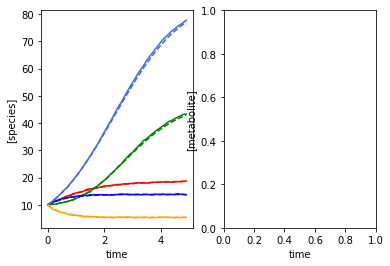

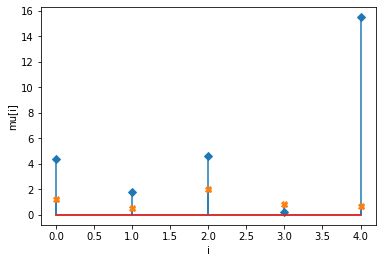

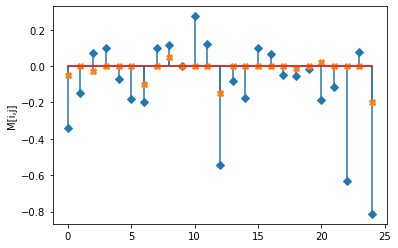

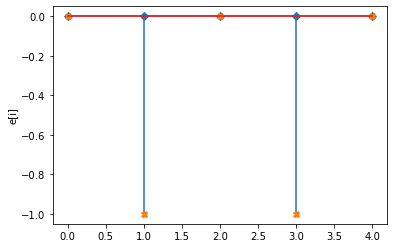

In [7]:
set_all_seeds(1234)

## SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
#TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct perturbation matrix
epsilon = np.array([0, -1, 0 , -1, 0])

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu,
                     epsilon=epsilon)
simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

# perturbation
tp = 2

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times, 
                                               sy0=np.hstack((init_species, init_metabolites)),
                                               tp=tp)


# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
# plot_gMLV(yobs, sobs, times)

## PERFORM REGRESSION
# time dependent perturbation
u = (times >= 2) & (times < 3) 
u = u.astype(int)
print('perturbation:\n', u)

# linearise
X, F = linearize_time_course_16S_u(yobs, times, u)
print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

# get the best lambda/alpha values on a grid via cross validation
a0, a1, a2 = fit_alpha_Ridge2(X, F, num_species=num_species, num_pert=1, n_a0=10, n_a1=10, n_a2=10)

# do final fit
mu_h, M_h, e_h = do_final_fit_Ridge2(X, F, num_species=num_species, num_pert=1, a0=a0, a1=a1, a2=a2)

predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h,
                     epsilon=e_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times,
                                                sy0=np.hstack((init_species, init_metabolites)),
                                                tp=tp)

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu,mu_h), M=(M, M_h), e=(np.array([0, -1, 0 , -1, 0]), e_h))


## Simulate some time course data and metabolites
This model assumes metabolite production is associated with abundance:  dS/dt = alpha X <br>
Note that this model needs rethinking as it cannot handle negative productivities <br>
In this simple example we don't need to infer the time course. We just linearize and estimate the elements of alpha with Lasso<br>
Number of metabolites is 6 here

number of species: 5
specific growth rates: [1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]
interaction matrix: 
[[-0.05  0.    0.    0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.    0.    0.    0.   -0.2 ]]
metabolite production: 
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0. ]]
perturbation matrix: 
[]
minimum found: a0/a1/error: 0.016237767391887217 8.858667904100832e-06 0.12034285709953198
unconstrained error        : 0.12228182158667038
minimum found: a/error: 0.6158482110660264 1.232535377243475
min + se rule: a/error: 1.2742749857031335 1.2447335692907107


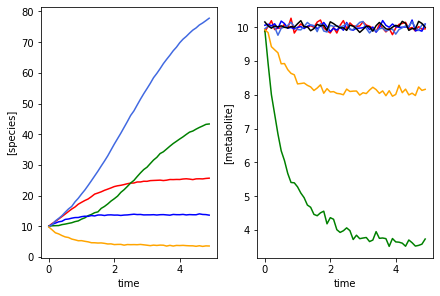

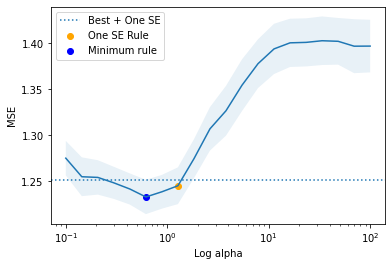

mu_hat/mu:
[ 2.33074275  1.17918873  5.94054837  0.66579005 18.7667204 ]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.13 -0.1   0.03  0.06 -0.03]
 [-0.12 -0.26  0.1   0.15  0.02]
 [ 0.14  0.16 -0.54 -0.11 -0.2 ]
 [ 0.07  0.1  -0.06 -0.07 -0.03]
 [-0.19 -0.22 -0.84  0.14 -0.91]]

 [[-0.05  0.    0.    0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.    0.    0.    0.   -0.2 ]]

a_hat/a:
[[-0.   -0.    0.    0.   -0.  ]
 [-0.12 -0.   -0.36 -0.    0.44]
 [-0.   -0.   -0.    0.   -0.  ]
 [ 0.   -0.    0.    0.   -0.  ]
 [-0.1   0.   -0.04 -0.    0.  ]
 [-0.   -0.    0.   -0.    0.  ]]

 [[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0. ]]


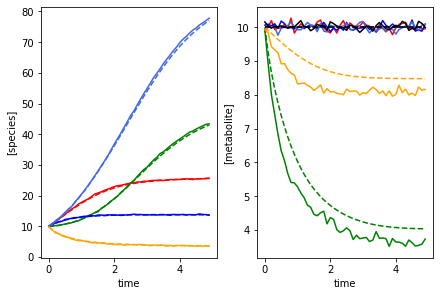

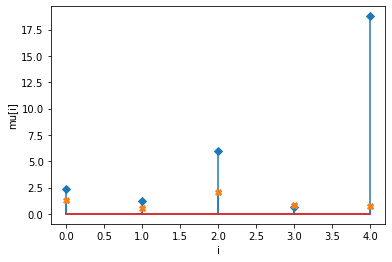

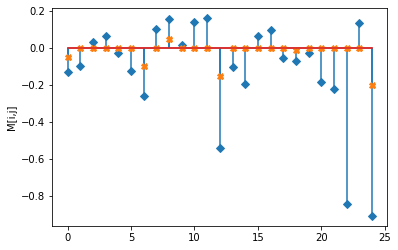

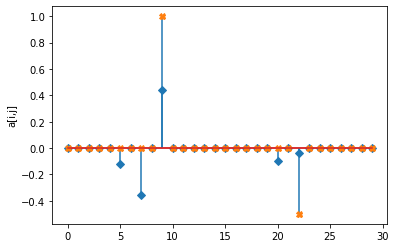

In [13]:
# Simulate some microbiota and metabolites
set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 6

# construct interaction matrix
#TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
# M[0,2] = -0.025
M[1, 3] = 0.05
# M[4,0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct metabolite production matrix
alpha = np.zeros((num_metabolites, num_species))
alpha[1, 4] = 1
alpha[4, 2] = -0.5

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu,
                     beta=alpha)
simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, _, _, _ = simulator.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
plot_gMLV(yobs, sobs, times)

## PERFORM REGRESSION
## fit growth first
# linearise
X, F = linearize_time_course_16S(yobs, times)
# print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

# get the best lambda/alpha values on a grid via cross validation
a0, a1 = fit_alpha_Ridge1(X, F, num_species=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0, a1)

## fit metabolite production
# Linearize this problem
G, S = linearise_time_course_metabolites(sobs, yobs, times)

# get the best lambda/alpha value on a grid via cross validation
a_min, a_se = fit_alpha_lasso(G, S, n_a=20)
model = Lasso(fit_intercept=False, max_iter=10000, alpha=a_min)

# perform final fit
model.fit(G, S)
alpha_h = model.coef_

predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h,
                     beta=alpha_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

compare_params(mu=(mu,mu_h), M=(M, M_h), alpha=(alpha, alpha_h))

## SIMULATE SOME DATA

number of species: 5
specific growth rates: [1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]
interaction matrix: 
[[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
metabolite production: 
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0. ]]
perturbation matrix: 
[]


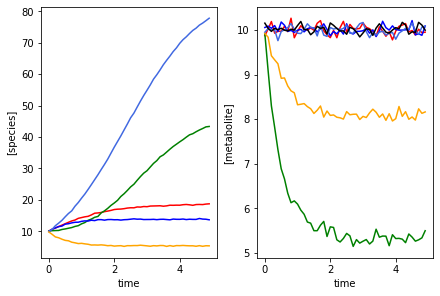

In [4]:
# Simulate some microbiota and metabolites
set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 6

# construct interaction matrix
#TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0,2] = -0.025
M[1, 3] = 0.05
M[4,0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct metabolite production matrix
rho = np.zeros((num_metabolites, num_species))
rho[1, 4] = 1
rho[4, 2] = -0.5

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu,
                     beta=rho)
simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, _, _, _ = simulator.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
plot_gMLV(yobs, sobs, times)

## FIT WITH MULTI-PENALTY LASSO

n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 40, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 40, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 40, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 40, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 40, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 39, n_features: 6, n_targets: 5
n_samples: 

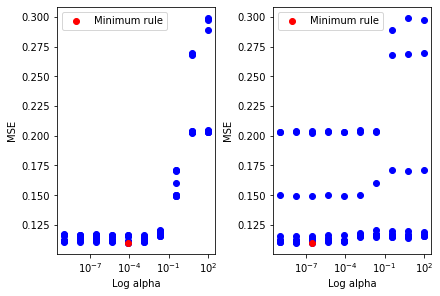

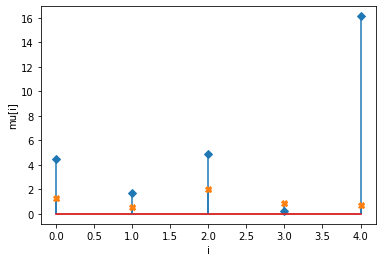

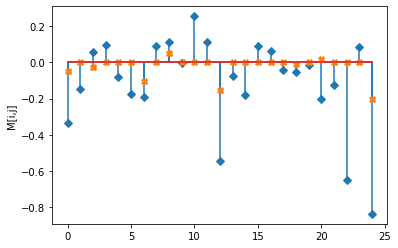

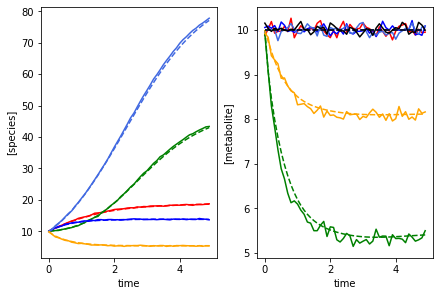

In [6]:
# F = dlnX/dt
DlnX = np.diff(np.log(yobs), axis=0)
Dt = np.tile(np.diff(times), (num_species, 1))
F = np.divide(DlnX, np.transpose(Dt))

# X matrix: stacked observed counts
mX = np.vstack([np.transpose(yobs), np.ones(len(times))])
tX = np.transpose(mX[:, :-1])

alphas = fit_alpha_MPLasso(tX, F, 10)

alpha = np.append(np.ones(num_species)*alphas[0], alphas[1])
model = MultiPenaltyLasso(alpha=alpha)
model.fit(tX, F)

mu_h = [model.coef_[i][-1] for i in range(0, num_species)]
M_h = [model.coef_[i][0:num_species].tolist() for i in range(0, num_species)]

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

# get prediction
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h,
                     beta=rho)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

## MARIA'S DATA

In [12]:
# import data
F = pd.read_csv('data/F.csv', delimiter = ',', header=None, index_col=None)
Y = pd.read_csv('data/Y.csv', delimiter = ',', header=None, index_col=None)

num_species = F.shape[0]
num_pert = Y.shape[0] - (num_species + 1)

# get the best lambda/alpha values on a grid via cross validation
a0, a1, a2 = fit_alpha_Ridge2(Y.T, F.T, num_species=num_species, num_pert=num_pert, n_a0=20, n_a1=20, n_a2=20)

# do final fit
mu_h, M_h, e_h = do_final_fit_Ridge2(Y.T, F.T, num_species, num_pert, a0, a1, a2)

M = np.array(M_h)
np.savetxt('M_pred.csv', M, delimiter=',')
mu = np.array(mu_h)
np.savetxt('mu_pred.csv', mu, delimiter=',')
e = np.array(e_h)
np.savetxt('e_pred.csv', e, delimiter=',')

theta = np.column_stack([M, mu, e])
F_pred = theta @ Y
np.savetxt('F_pred.csv', F_pred, delimiter=',')

minimum found: a0/a1/a2/error: 335.9818286283774 1000.0 1000.0 0.7237779672823516
unconstrained error        : nan


/home/ajfedorec/GitHub/gMLV/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ajfedorec/GitHub/gMLV/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ajfedorec/GitHub/gMLV/gMLV/gMLV_ML.py", line 62, in fit
    self.coef_ = ridge_fit_pert(X.T, y.T, self.alphas, self.num_species, self.num_pert)
  File "/home/ajfedorec/GitHub/gMLV/gMLV/gMLV_ML.py", line 96, in ridge_fit_pert
    beta = np.dot(F, X.T) @ la.inv(X

InvalidIndexError: (slice(None, None, None), None)

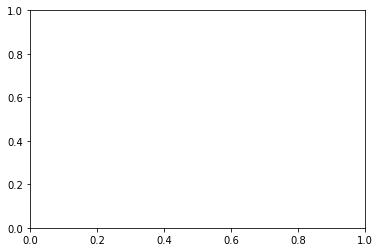

'/home/ajfedorec/GitHub/gMLV'